# Assignment - 3
## Donal Loitam(AI21BTECH11009)

In [45]:
%matplotlib inline

import time
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

### Helper functions 

In [36]:
def DFT(I: np.ndarray):
    '''
    Calculates the MN point DFT of an image using the complex exponential matrix

    Args:
        I: The input image
    Returns:
        The corresponding DFT coefficients of the Image
                                                                                            '''
    
    N, M = I.shape[0], I.shape[1]
    
    row_ind = np.arange(N).reshape(N, 1)
    col_ind = np.arange(M).reshape(1, M)
                
    c1 = np.exp(-2 * np.pi * 1j / N)
    dft_matrix_row = c1 ** (row_ind * col_ind)
            
    c2 = np.exp(-2 * np.pi * 1j / M)
    dft_matrix_col = c2 ** (row_ind * col_ind)
              
    return np.dot(np.dot(dft_matrix_row, I), dft_matrix_col) 



def IDFT(I_hat):
    '''
    Calculates the IDFT of an image using the complex exponential matrix

    ARGS:
        I_hat: The DFT of the input image
    
    Returns:
        I: the synthesized image
                                                                                            '''
    
    N, M = I_hat.shape[0], I_hat.shape[1]
    
    row_ind = np.arange(N).reshape(N, 1)
    col_ind = np.arange(M).reshape(1, M)
                
    c1 = np.exp(2 * np.pi * 1j / N)
    idft_matrix_row = c1 ** (row_ind * col_ind)
            
    c2 = np.exp(2 * np.pi * 1j / M)
    idft_matrix_col = c2 ** (row_ind * col_ind)
            
        
    I = np.dot(np.dot(idft_matrix_row, I_hat), idft_matrix_col)
    I = I / (N * M)
    
    return I.astype(np.int64)


def linear_point_operations(I:np.ndarray, scale, offset):
    """ 
        Performs a simple linear point operation on the input numpy array 
          Args:
              I: The image array as a numpy 2d array
              P: Scaling factor
              L: The offset factor
          Returns:
                  The result of the applied linear operation on the input array(image)
          
                                                                                                """
    J = I*scale + offset
    return np.clip(J, 0, 255).astype(np.uint8)         # for dtype consistency



def FSCS(I: np.ndarray, K = 256):
    """ 
        Performs Full Scale Contrast Stretch(FSCS) on the given image.
            Args:
                 I : the input Image as numpy 2d array
                 K : the number of gray levels(256 default)
            Returns:
                Full Scale Constrast Stretched Image.
                                                                """
    
    # Solve: PA + L = 0
    #        PB + L = K - 1
    
    max_gray_value = np.max(I)
    min_gray_value = np.min(I) 
    
    scale = (K - 1)/(max_gray_value - min_gray_value)
    offset = -min_gray_value * scale
    
    return linear_point_operations(I, scale, offset)


def log_magnitude_compression(I: np.ndarray):
    """ 
        Performs Log magnitude commpression on the given input image.
            Args:
                 I : the input Image as numpy 2d array
            Returns:
                Log magnitude compressed Image.
                                                                """
    if np.max(I) == 255:
        I_log = np.log(I.astype(np.float32) + 1)  # Convert to float to avoid overflow
    else:
        I_log = np.log(I + 1)
        
    return FSCS(I_log)   # Always followed by FSCS


def centered_dft(I: np.ndarray):
    
    N, M = I.shape[0], I.shape[1]
    i, j = np.indices((N, M))
    
    new_I = I * (-1) ** (i + j)
    
    return DFT(new_I)

### Load images and print shape

In [3]:
# Load Images
rgb_I1 = plt.imread('4.2.03.tiff')
I1 = np.dot(rgb_I1[...,:3], [0.2989, 0.5870, 0.1140])
I2 = plt.imread('5.1.13.tiff')
I3 = plt.imread('7.1.02.tiff')
print(I1.shape)
print(I2.shape)
print(I3.shape)

(512, 512)
(256, 256)
(512, 512)


## 1 Periodic Convolution
Q 1. Write a program to circularly convolve two images. Test your program by using an image and an averaging filter of
size 5 × 5. Verify that the IDFT of the product of the image and filter DFT does indeed result in circular convolution.
(5)

In [65]:
def circular_conv(I, kernel, linear=False):
    
    I_height, I_width = I.shape
    kernel_height, kernel_width = kernel.shape
    
    # Flip the kernel both horizontally and vertically
    kernel = np.flipud(np.fliplr(kernel))
    
    result = np.zeros_like(I)
    
    pad_h = kernel_height // 2
    pad_w = kernel_width // 2
    
    # Circular convolution
    if not linear:                              
        # Pad the I using the 'wrap' mode for circular convolution
        padded_I = np.pad(I, ((pad_h, pad_h), (pad_w, pad_w)), mode='wrap')
        
        for i in range(I_height):
            for j in range(I_width):
                # Perform element-wise multiplication between the kernel and the region extracted
                region = padded_I[i:i+kernel_height, j:j+kernel_width]
                conv_result = np.sum(region * kernel)
                result[i, j] = conv_result
                
    # Linear convolution (with zero padding)
    else:                                                   
        # Pad the I using the 'constant' mode for linear convolution
        padded_I = np.pad(I, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
        
        for i in range(I_height):
            for j in range(I_width):
                # Perform element-wise multiplication between the kernel and the region extracted
                region = padded_I[i:i+kernel_height, j:j+kernel_width]
                conv_result = np.sum(region * kernel)
                result[i, j] = conv_result
    
    return result


def circular_conv_via_DFT(I, kernel):
    '''
    Performs Circular convolution of I with a kernel via DFT.

    Args:
        I: The image
        kernel: The kernel

    Returns:
        The circularly convolved Image
                                                                                                '''

    N, M = I.shape
    n, m = kernel.shape
    
    # Pad kernel to match image size
    padded_kernel = np.pad(kernel, [[0, N - n], [0, M - m]], mode='constant', constant_values=0)

    # Calculate DFT of image and padded kernel
    image_dft = DFT(I)
    kernel_dft = DFT(padded_kernel)
    
    # Element-wise multiplication qnd take IDFT 
    product_dft = image_dft * kernel_dft    
    result_conv = IDFT(product_dft)
    
    return result_conv

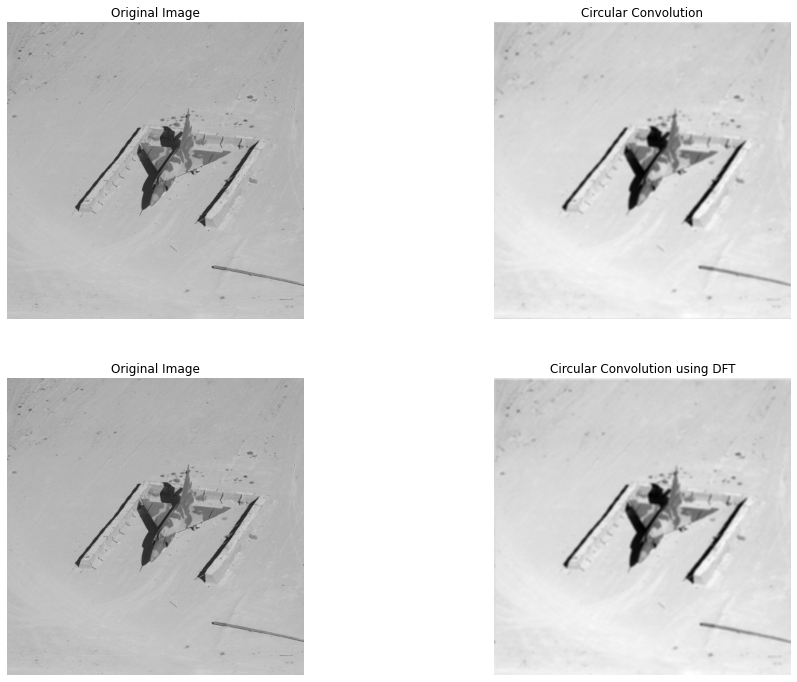

In [66]:
# defining the 5x5 averaging filter
kernel = np.ones((5 , 5)) / 25

# plotting the results
plt.figure(figsize = (16, 12))

plt.subplot(2 , 2 , 1)
plt.imshow(I3 , cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(2 , 2 , 2)
plt.imshow(circular_conv(I3 , kernel) , cmap = 'gray')
plt.axis('off')
plt.title("Circular Convolution")

plt.subplot(2 , 2 , 3)
plt.imshow(I3 , cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(2 , 2 , 4)
plt.imshow(circular_conv_via_DFT(I3 , kernel) , cmap = 'gray')
plt.axis('off')
plt.title("Circular Convolution using DFT")

plt.show()

### As can be seen, both circularly convolved outputs looks similar.

Q 2. Linearly convolve the same image and filter using the circular convolution function above after appropriate zero
padding

In [6]:
def linear_conv_using_circular_conv(I , kernel):
    '''
        Performs linear convolution of image with a kernel via circular_conv .
    
    Args:
        I: The image
        kernel: The kernel

    Returns:
        The linearly convolved image
                                                                                                        '''
    return circular_conv(I , kernel, True)

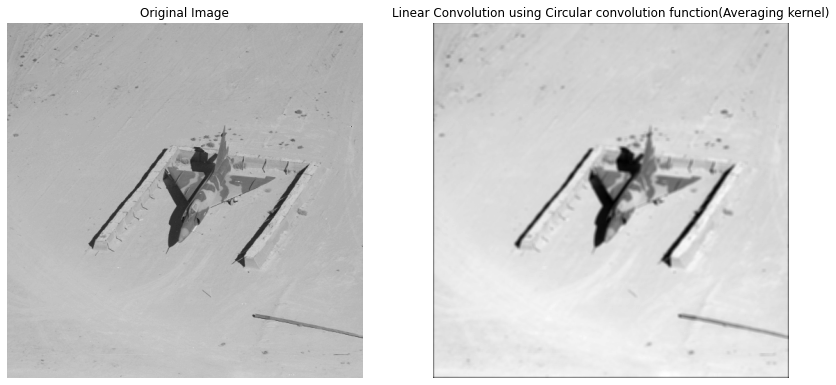

In [68]:
plt.figure(figsize=(14, 8))

plt.subplot(1 , 2 , 1)
plt.imshow(I3 , cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1 , 2 , 2)
plt.imshow(linear_conv_using_circular_conv(I3 , kernel) , cmap = 'gray')
plt.axis('off')
plt.title("Linear Convolution using Circular convolution function(Averaging kernel)")

plt.show()

Q 3. Experiment with different filter kernel sizes and present your observation on when direct linear convolution is faster
than the IDFT-DFT approach using zero padding. 

In [50]:
def linear_conv_DFT(I , kernel):
    '''
        Performs linear convolution of image with a kernel using DFT-IDFT.

    Args:
        I: The image
        kernel: The kernel

    Returns:
        The linearly convolved image
    '''

    M , N = I.shape
    k_w , k_h = kernel.shape

    # pad the kernel and image to sizes 2M , 2N
    kernel_padded = np.zeros((2*M , 2*N))    
    I_padded = np.zeros((2*M , 2*N))

    I_padded[ : M , : N] = I
    kernel_padded[: k_w , : k_h] = kernel

    I_dft = DFT(I_padded)
    kernel_dft = DFT(kernel_padded)

    product_dft = I_dft * kernel_dft

    return IDFT(product_dft)[: M , : N]

In [61]:
kernel_sizes = [3, 10, 20, 50, 100] 

# Repeat for n_reps times,
n_reps = 5

I_size = 512  # Use fixed image size for testing
I = np.random.rand(I_size, I_size)

for k_size in kernel_sizes:
    print(f"kernel size {k_size}x{k_size}:")
    total_time_DFT = 0
    total_time_circular = 0
    
    for _ in range(n_reps):
        # Define the average kernel
        kernel = np.ones((k_size , k_size)) / (k_size*k_size)
        
        # Measure the time for DFT way
        start_time = time.time()
        _ = linear_conv_DFT(I, kernel)
        total_time_DFT += time.time() - start_time
        
        # Measure the time for direct linear convolution way
        start_time = time.time()
        _ = linear_conv_using_circular_conv(I, kernel)
        total_time_circular += time.time() - start_time

    avg_time_DFT = total_time_DFT / n_reps
    avg_time_circular = total_time_circular / n_reps

    print(f"Average time for linear_conv_DFT: {avg_time_DFT:.4f} seconds")
    print(f"Average time for linear_conv_using_circular_conv: {avg_time_circular:.4f} seconds")
    print()

kernel size 3x3:
Average time for linear_conv_DFT: 4.9793 seconds
Average time for linear_conv_using_circular_conv: 1.8434 seconds

kernel size 10x10:
Average time for linear_conv_DFT: 2.0771 seconds
Average time for linear_conv_using_circular_conv: 3.1860 seconds

kernel size 20x20:
Average time for linear_conv_DFT: 2.0387 seconds
Average time for linear_conv_using_circular_conv: 3.1612 seconds

kernel size 50x50:
Average time for linear_conv_DFT: 1.1343 seconds
Average time for linear_conv_using_circular_conv: 6.1625 seconds

kernel size 100x100:
Average time for linear_conv_DFT: 1.1741 seconds
Average time for linear_conv_using_circular_conv: 4.4765 seconds



## Observations: 
- For smaller filter kernel sizes relative to the image size, direct linear convolution tends to be faster. 
- However, as we increase the kernel size, the IDFT-DFT approach becomes faster
- IDFT-DFT approach has some additional overhead due to the DFT and IDFT computation operations, which may be significant if the kernel size is small. It may outweigh its computational benefits and it can be seen from the above experiment

#### In conclusion, To convolve an N X M image with a P x Q filter:
If P, Q << N, M, faster to convolve in space domain

# 2. Linear Image Filters
We discussed various linear image filters in class. In this problem you will experiment with the various design parameters
to develop intuition on how to select them.

Q 1. What is the filter parameter of the averaging filter? Experiment with different parameters and plot the DFT magnitude
spectrum at each parameter setting. Verify that this is indeed a low pass filter. What can you infer from the filter
spectrum in relation to the parameter values?

### Ans:
- The filter parameter of an averaging filter = size of the filter kernel = M 
(or) the size of the neighborhood over which the averaging is to be performed. 

- It determines how much smoothing or blurring effect of the filter on the image.

In [8]:
def averaging_filter(M: int):
    filter_kernel = np.ones((M, M))/(M * M)
    return filter_kernel


def plot_dft_magnitude(filter_sizes):
    num_rows = len(filter_sizes) // 2 + len(filter_sizes) % 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
    
    for i, M in enumerate(filter_sizes):
        filter_kernel = averaging_filter(M)
        dft = centered_dft(filter_kernel)
        dft_mag = np.abs(dft)
        
        row = i // 2
        col = i % 2
        im = axs[row, col].imshow(log_magnitude_compression(dft_mag), cmap='gray')
        axs[row, col].set_title(f"DFT Magnitude (Log compressed), Filter Size {M}x{M}")
        
        axs[row, col].set_xlabel('Column Index')
        axs[row, col].set_ylabel('Row Index')
        
        cbar = plt.colorbar(im, ax=axs[row, col], orientation='vertical')
        cbar.set_label('Magnitude')
    
    plt.tight_layout()
    plt.show()

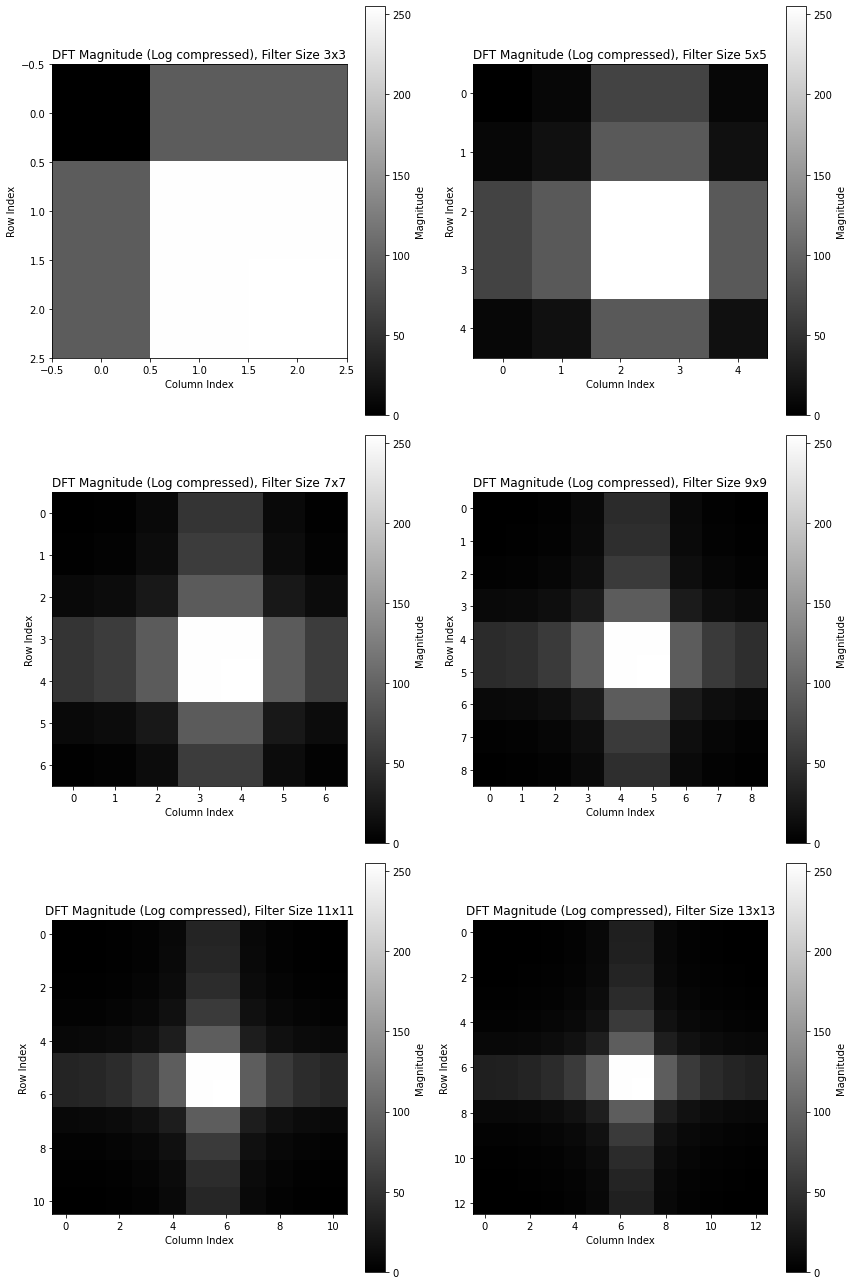

In [9]:
# loop over different sizes
filter_sizes = [3, 5, 7, 9, 11, 13]  
plot_dft_magnitude(filter_sizes)

## Answer : 
As can be seen from the spectrum, this indeed is a low pass filter, becasue of the presence of higher values in the center and lower values as it goes far away from center. It's frequency response is characterized by attenuating high-frequency components while preserving low-frequency components

Inference from the spectrum
- As we increase the filter size, the low frequency components in the DFT magnitude spectrum becommes more prominent. Also, as kernel size increases, the higher values become more and more centered

## Question
Q 2. What are the filter parameters of the Gaussian filter? Experiment with different parameters and plot the DFT magnitude spectrum at each parameter setting. Verify that this is indeed a low pass filter. What can you infer from the filter spectrum in relation to the parameter values?

### Ans: 
There are mainly 2 parameters of a gaussian filter namely :- 
- the standard deviation ($\sigma$) and the size of the filter kernel(M)
- While $\sigma$ controls the spread of the gaussian distribution as expected
- M(filter size) determines how much of the neighbouring pixels to be influenced by the filter

In [10]:
def gaussian_filter(sigma, M):

    filter_ = np.ones((M , M)) / (2 * np.pi * sigma**2)
    center = M // 2
    
    # Centering the gaussian filter
    for i in range(M):
        for j in range(M):
            filter_[i, j] *= np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))
    
    filter_ /= np.sum(filter_)        # normalise
    
    return filter_    
    

def plot_dft_magnitude(parameters_arr):
    num_rows = len(parameters_arr) // 2 + len(parameters_arr) % 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
    
    for i, params in enumerate(parameters_arr):
        sigma, M  = params
        filter_kernel = gaussian_filter(sigma, M)
        dft = centered_dft(filter_kernel)
        dft_mag = np.abs(dft)
        
        row = i // 2
        col = i % 2
        im = axs[row, col].imshow(log_magnitude_compression(dft_mag), cmap='gray')
        axs[row, col].set_title(f"DFT Magnitude, Filter Size {M}x{M}, sigma={sigma}")
        
        axs[row, col].set_xlabel('Column Index')
        axs[row, col].set_ylabel('Row Index')
        
        cbar = plt.colorbar(im, ax=axs[row, col], orientation='vertical')
        cbar.set_label('Magnitude')
    
    plt.tight_layout()
    plt.show()

Experimenting the impact of increasing filter sizes on the Magnitude spectrum(Sigma = fixed) \ n


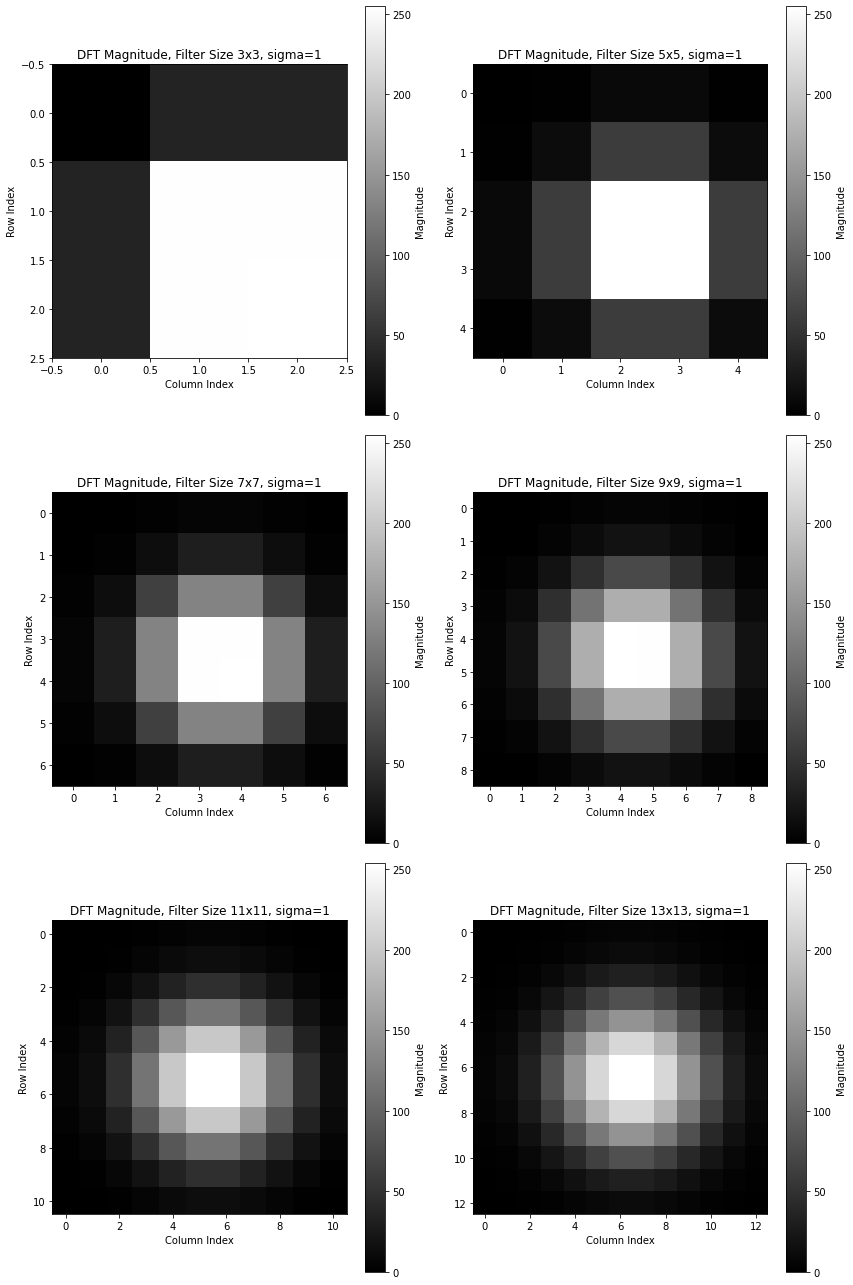

In [11]:
## First, we fix sigma and experiment with different filter_sizes
sigma = 1
filter_parameters = [(sigma, 2 * i + 1) for i in range(1, 7)] 
print("Experimenting the impact of increasing filter sizes on the Magnitude spectrum(Sigma = fixed) \ n")
plot_dft_magnitude(filter_parameters)

Experimenting the impact of increasing filter sizes on the Magnitude spectrum(Sigma = fixed)


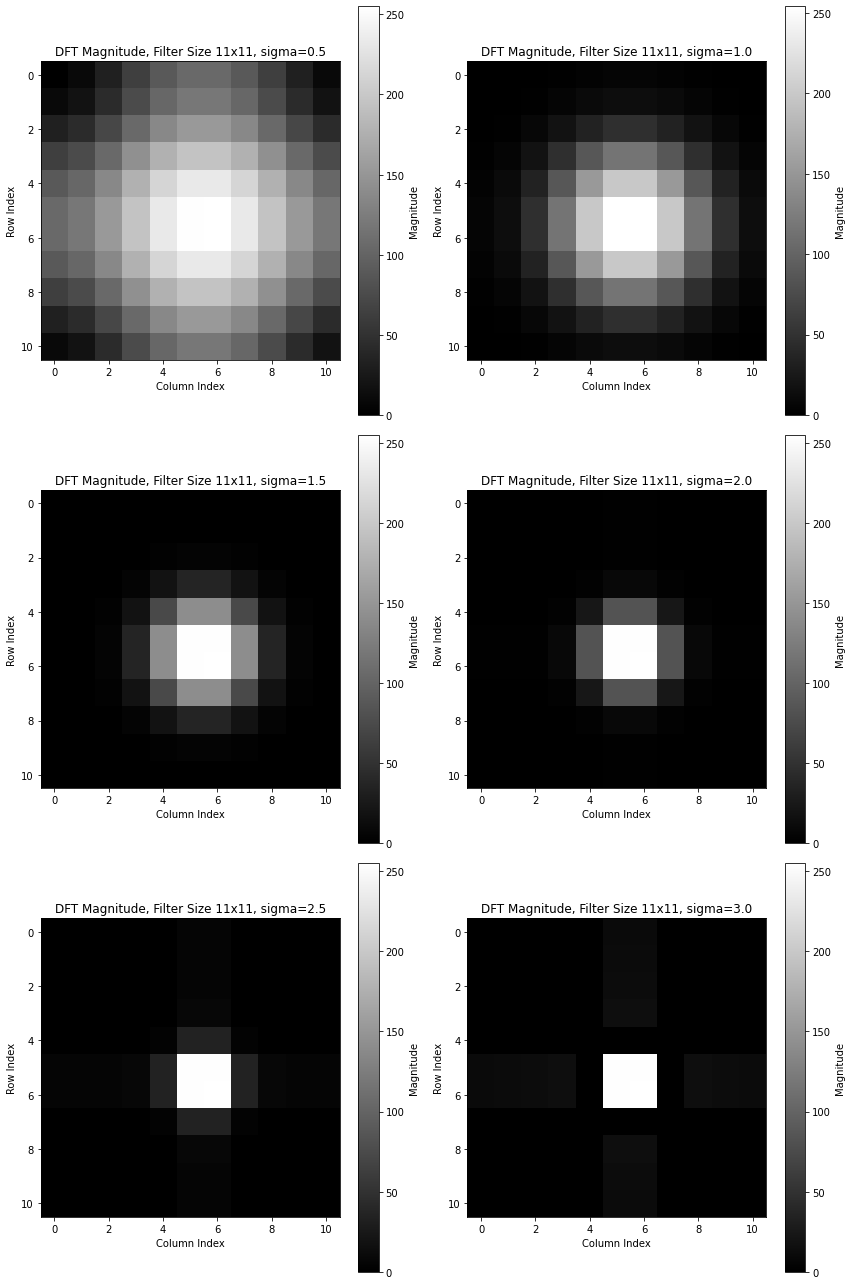

In [12]:
## Now fix filter_size and experiment with different sigmas
filter_size = 11
filter_parameters = [(i, 11) for i in np.arange(0.5, 3.5, 0.5)]
print("Experimenting the impact of increasing filter sizes on the Magnitude spectrum(Sigma = fixed)")
plot_dft_magnitude(filter_parameters)

## Observations :
- Increasing $\sigma$ (keeping fitler size = constant)
    - Increasing sigma for typically leads to a smoother and broader kernel shape in the spatial domain, which implies a narrower kernel in the frequency domain (DFT) [As can be seen from the diagram]
    - In other words, it allows for more low-frequency components to pass through and attenuates higher frequencies.
    
- Increasing filter size (keeping $\sigma$ = constant)
    - Increasing M of the Gaussian kernel while keeping $\sigma$ constant leads to a wider kernel in the spatial domain.
    -  Which corresponds to a narrower kernel in the frequency domain

## Ques
Q 3. Generate a band pass filter by taking the difference of two Gaussian filters. Verify from the DFT magnitude spectrum
that this is indeed a band pass filter. What are the parameters of this filter? Experiment with various parameters
values of the individual Gaussians. What can you infer from the filter spectrum in relation to the parameter values?

### Band pass filter

In [13]:
def bandpass_filter(sigma1, sigma2, M: int):
    if sigma1 > sigma2:
        raise ValueError("sigma1 must be less than sigma2 in the Difference of Gaussian(DoG) filter.")
    
    Gaussian1_filter = gaussian_filter(sigma1, M)
    Gaussian2_filter = gaussian_filter(sigma2, M)
    bandpass_kernel = Gaussian1_filter - Gaussian2_filter

    return bandpass_kernel



def plot_dft_magnitude(parameters_arr):
    num_rows = len(parameters_arr) // 2 + len(parameters_arr) % 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
    
    for i, params in enumerate(parameters_arr):
        sigma1, sigma2, M  = params
        filter_kernel = bandpass_filter(sigma1,sigma2, M)
        dft = centered_dft(filter_kernel)
        dft_mag = np.abs(dft)
        
        row = i // 2
        col = i % 2
        im = axs[row, col].imshow(log_magnitude_compression(dft_mag), cmap='gray')
        axs[row, col].set_title(f"DFT Magnitude, sigma1={sigma1}, sigma2={sigma2}")
        
        axs[row, col].set_xlabel('Column Index')
        axs[row, col].set_ylabel('Row Index')
        
        cbar = plt.colorbar(im, ax=axs[row, col], orientation='vertical')
        cbar.set_label('Magnitude')
    
    plt.tight_layout()
    plt.show()

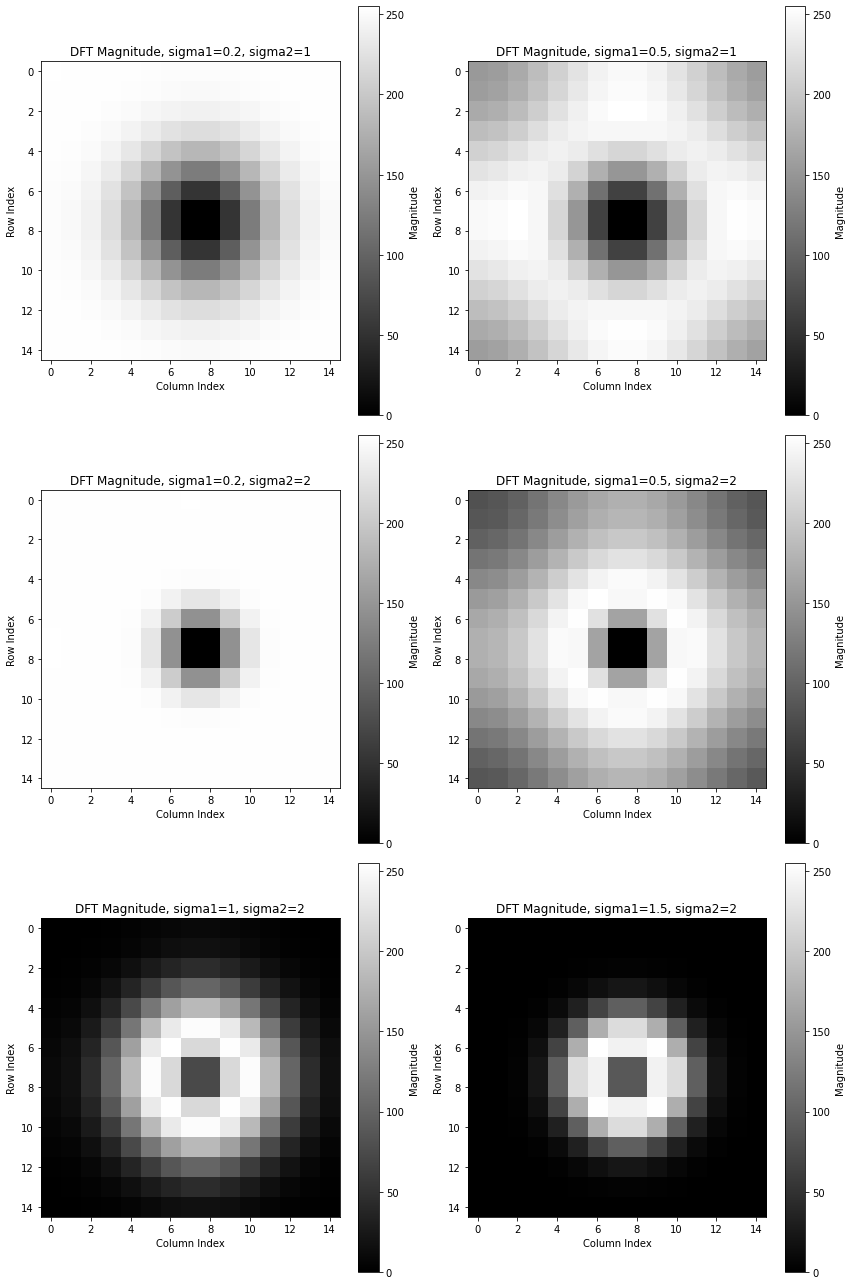

In [14]:
filter_parameters = [(0.2, 1, 15), (0.5, 1, 15), (0.2, 2, 15), (0.5, 2, 15), (1, 2, 15), (1.5, 2, 15)]  
plot_dft_magnitude(filter_parameters)

### Answer : 
- The DFT spectrum indeed verifies it to be band-pass because :-
    - Low values near the centre(0, 0) and far away
    - High values between the two low value regions of the magnitude spectrum
- $\sigma_1$ and $\sigma_2$ control the spread of the Gaussian distributions for the two filters.
- By definition, the band-pass filter allows a specific range of frequencies (bandwidth) to pass while attenuating frequencies outside this range.
- They determine the bandwidths of the low-pass and high-pass parts of the band-pass filter.
- The bandwidth of the passband is influenced by the difference in sigma values ($\sigma_1$ - $\sigma_2$). 
- More the difference, wider the passband, and a smaller difference will result in a narrower passband[As can be seen from the plots]

## Ques
Q 4. Plot the DFT magnitude spectrum of a Laplacian filter. Verify that this is a high pass filter. (1)

In [15]:
def laplacian_filter():
    lap_kernel = np.ones((3, 3), dtype=np.int32)
    lap_kernel[1, 1] = -4
    lap_kernel[0, 0] = lap_kernel[0, 2] = lap_kernel[2, 0] = lap_kernel[2, 2] = 0  
    return lap_kernel


def plot_dft_magnitude():
    filter_kernel = laplacian_filter()
    
    dft = np.fft.fft2(filter_kernel)
    dft_shifted = np.fft.fftshift(dft)
    magnitude_spectrum = np.abs(dft_shifted)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(log_magnitude_compression(magnitude_spectrum), cmap='gray')
    plt.title('Magnitude Spectrum of Laplacian Filter')
    plt.xlabel('Row Index')
    plt.ylabel('Column Index')
    plt.colorbar()
    plt.show()

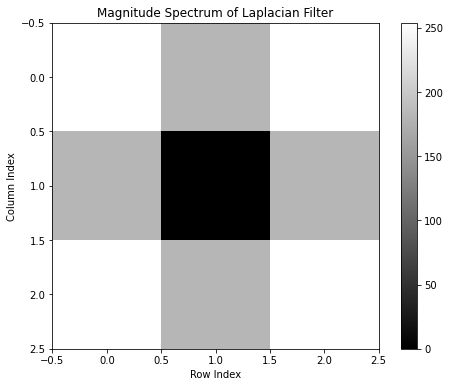

In [16]:
laplacian_kernel = laplacian_filter()
plot_dft_magnitude()

### Answer
- Lower value at the centre and higher values as we go far away from the center indicate it as a high-pass filter

## 3 Applications of Linear Filters


Q 1. In this problem you will denoise images using the linear filtering techniques discussed in class. Like the last assignment, use additive white Gaussian noise (AWGN) with zero mean and variance $σ^2$ = 25. Write a program to denoise the image using the following techniques:

- (a) Average filter of size M × M. Vary M from 3 to 15 in increments of 2 and observe the tradeoff between denoising and smoothing. What is an optimal window size for this noise level? (1)


In [17]:
def AWGN(I , mean = 0, std = 5):
    '''
        Adds white Gaussian noise (AWGN) with zero(by defualt) mean and standard deviation = std(5 by default)
    
    Args:
        I : the image to which noise has to be added
        mean : the mean of the noise, default is 0
        std : the standard deviation of the noise, default is 5

    Returns:
        the New image with noise added
                                                                                                        '''

    return I + np.random.normal(mean , std , I.shape)

#### a) Average filter of different sizes

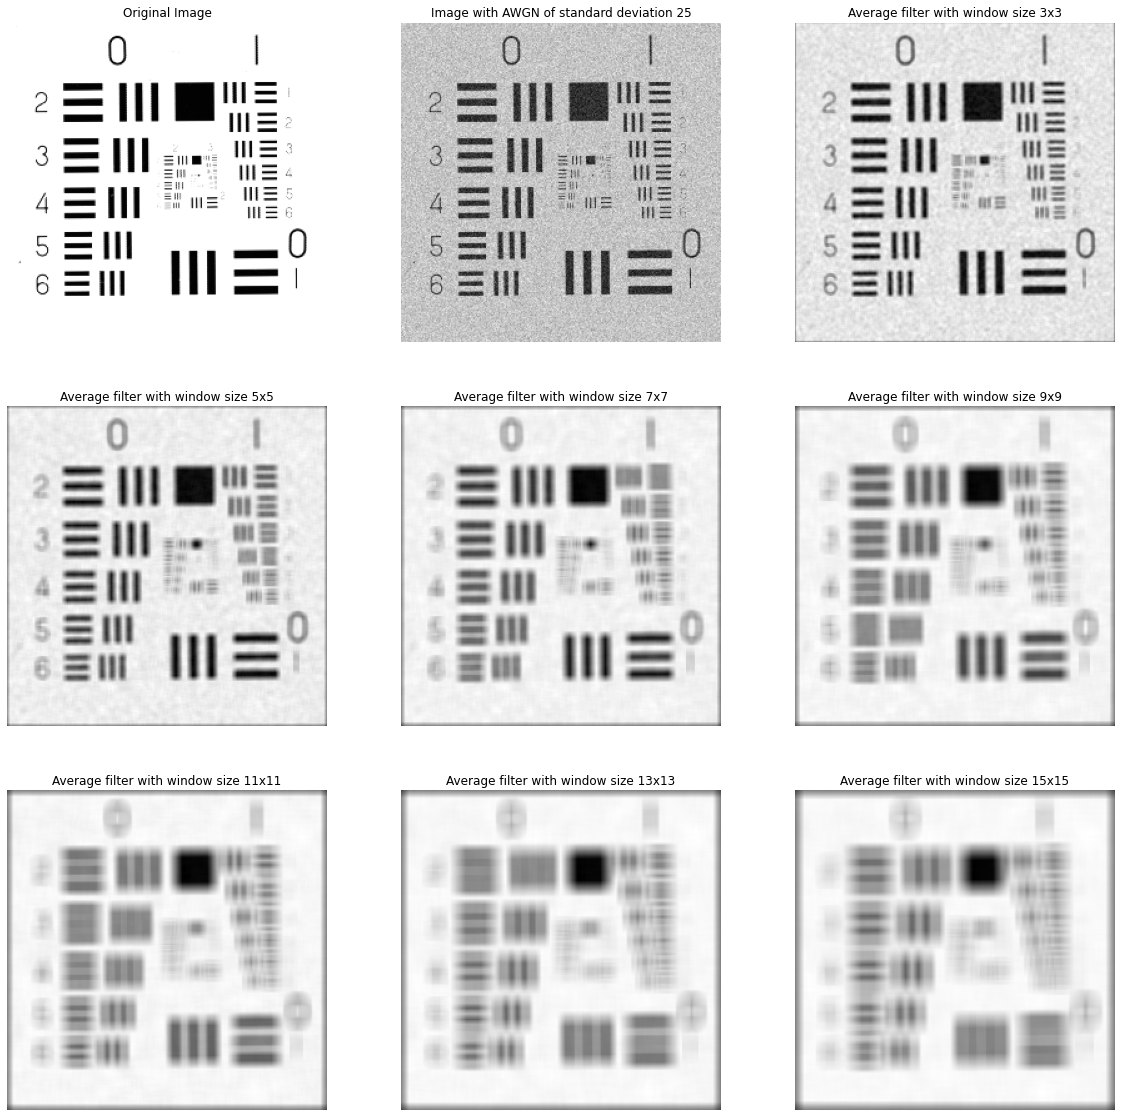

I think the window size of 5, 7 or even 9 is the most suitable for the image, depending on the task !


In [18]:
noisy_img2 = AWGN(I2 , 0 , 25)
plt.figure(figsize = (20 , 20))

plt.subplot(3 , 3 , 1)
plt.imshow(I2 , cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(3 , 3 , 2)
plt.imshow(noisy_img2 , cmap = 'gray')
plt.axis('off')
plt.title("Image with AWGN of standard deviation 25")


# Varying average filter between 3 and 15
for idx , M in enumerate(range(3 , 16 , 2)):
    plt.subplot(3 , 3 , idx + 3)
    plt.imshow(linear_conv_using_circular_conv(noisy_img2, averaging_filter(M)) , cmap = 'gray')
    plt.axis('off')
    plt.title(f"Average filter with window size {M}x{M}")  

plt.show()

print("I think the window size of 5, 7 or even 9 is the most suitable for the image, depending on the task !")

### Ans: 
- As we increase the filter size, the amount of smoothing applied to the image also increases. A larger filter considers more neighboring pixels when computing the average, resulting in more blur as can be seen
- However, more smoothing effectively reduces noise in the image but it may also blur out fine details and edges.
- Smaller filters like 3 x 3, 5 x 5 have some amount of smoothing and preserve fine details relatively.
- While with larger filters like 11 x 11 or more, the denoising capability improves, but at the cost of increased blurring and loss of detail.

### b) Gaussain filters
- (b) Gaussian filter of size 5 × 5. Experiment with the standard deviation $σ_h$ of the filter from 0.5 to 5 in steps of 0.5 and observe its effect on denoising. What happens when you keep the standard deviation of the filter constantbut vary the kernel size?


 Seeing the effect of standard deviation of the filter on Denoising(filter size constant) 



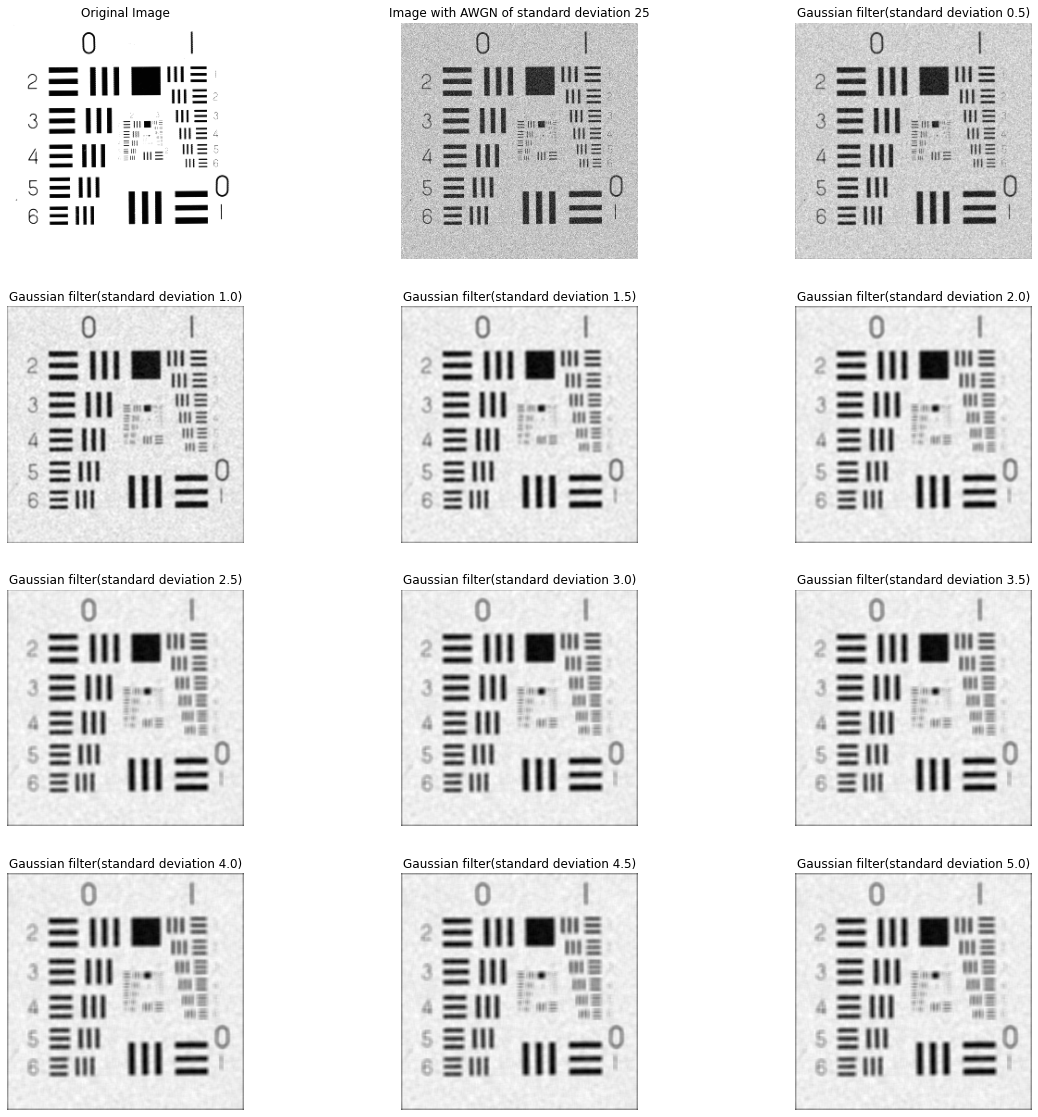

In [19]:
print("\n Seeing the effect of standard deviation of the filter on Denoising(filter size constant) \n")
plt.figure(figsize = (20 , 20))

plt.subplot(4 , 3 , 1)
plt.imshow(I2 , cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(4 , 3 , 2)
plt.imshow(noisy_img2 , cmap = 'gray')
plt.axis('off')
plt.title("Image with AWGN of standard deviation 25")

# Fix the window size to be 5 x 5 and vary the sigma(standard deviation) of the gausssian filter 
M = 5
for idx, k in enumerate(range(1 , 11)):
    sigma = k/2
    gauss_filter = gaussian_filter(sigma, M) 
    plt.subplot(4 , 3 , idx + 3)
    plt.imshow(linear_conv_using_circular_conv(noisy_img2, gauss_filter) , cmap = 'gray')
    plt.axis('off')
    plt.title(f"Gaussian filter(standard deviation {k/2})")

plt.show()


 Seeing the effect of filter size on Denoising(Standard deviation constant) 



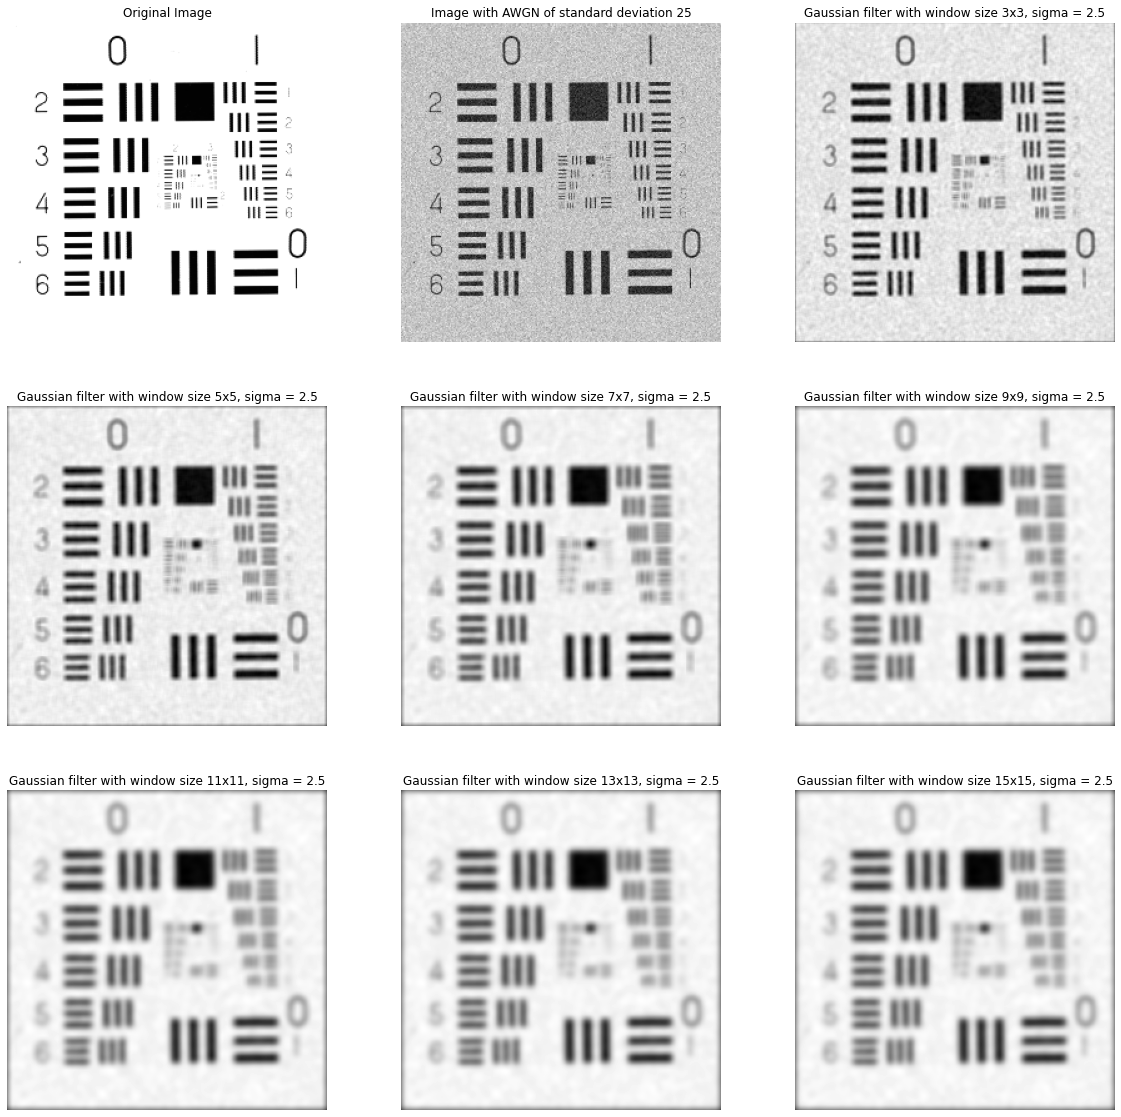

In [20]:
print("\n Seeing the effect of filter size on Denoising(Standard deviation constant) \n")
plt.figure(figsize = (20 , 20))

plt.subplot(3 , 3 , 1)
plt.imshow(I2 , cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(3 , 3 , 2)
plt.imshow(noisy_img2 , cmap = 'gray')
plt.axis('off')
plt.title("Image with AWGN of standard deviation 25")


# Varying average filter between 3 and 15
sigma = 2.5
for idx , M in enumerate(range(3 , 16 , 2)):
    plt.subplot(3 , 3 , idx + 3)
    plt.imshow(linear_conv_using_circular_conv(noisy_img2, gaussian_filter(sigma, M)) , cmap = 'gray')
    plt.axis('off')
    plt.title(f"Gaussian filter with window size {M}x{M}, sigma = {sigma}")  

plt.show()

### Answer :
- Effect of Standard Deviation ($\sigma$):
    - Increasing the standard deviation of the gaussian kernel increases denoising since it implies a wider spread of the gaussain function => more blurring of the image
    - While decreasing $\sigma$ meaning a narrower Gaussian function, leading to less blurring of the image. Although it may preserve fine details, it also retains more noise.
    - Hence there exist a tradeoff


- Effect of Varying Kernel Size(Keeping $\sigma$ contant):
    - Increasing the kernel size (like moving from a 5x5 to a 7x7 or larger filters) results in more smoothing and blurring of the image. This reduces noise at the cost of loss of finer details and edges.
    - Decreasing the kernel size (like moving from a 7x7 to 5x5  or smaller filters) results in less smoothing and blurring. This does preserve finer details, but it also keeps more noise, hence  a less smooth output image.
    - As with the previous case, this is a tradeoff between noise reduction and preservation of image details

### Question
Q 2. In this problem you will explore how edge detection and enhancement can be achieved using linear band pass and
high pass filters. Work with the mandrill image (from the USC dataset) in this question. Apply each of the band pass
and high pass filters you designed in Question 2 to this image and observe the output. Tabulate your observations for
each filter parameter choice.

### Band pass filters

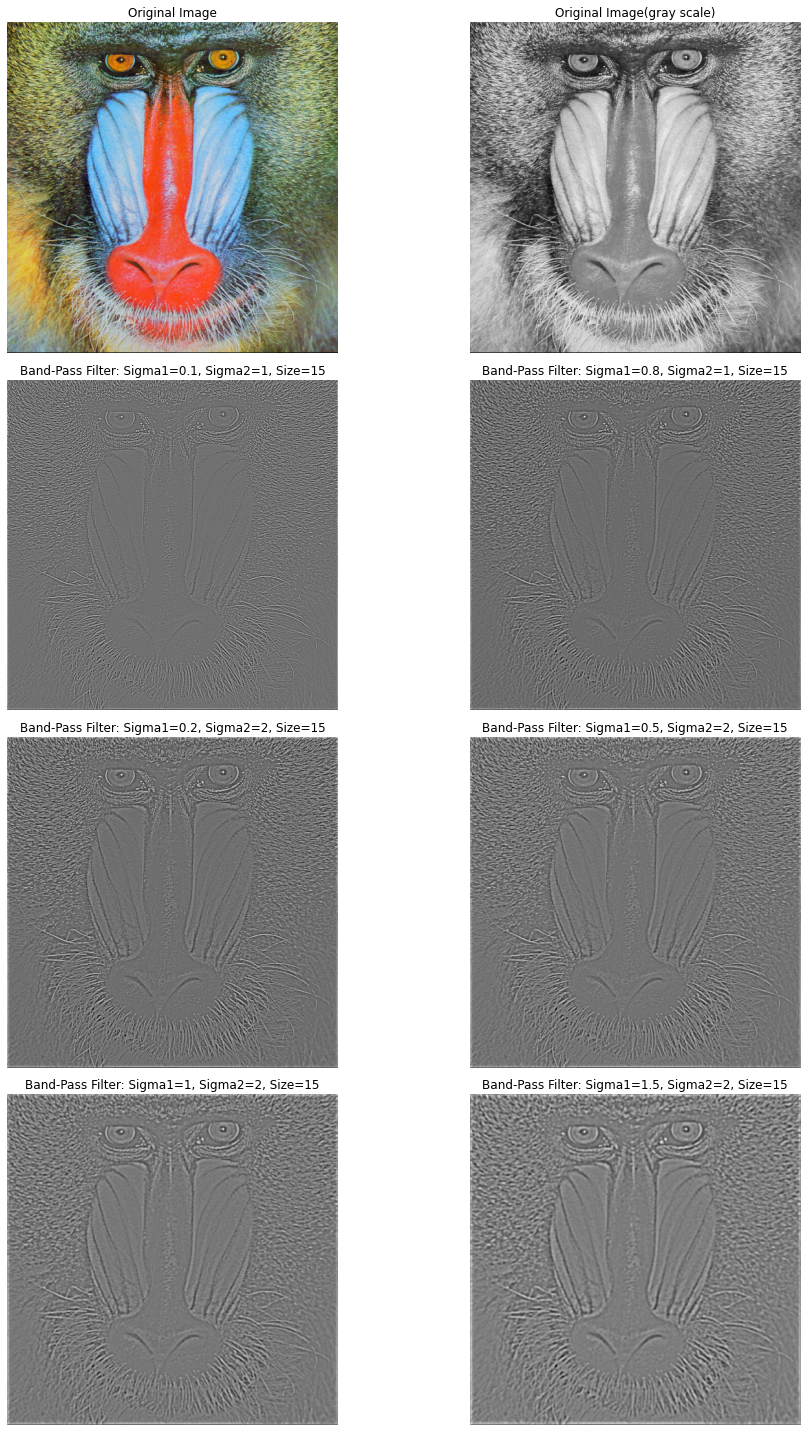

In [59]:
filter_parameters = [(0.1, 1, 15), (0.8, 1, 15), (0.2, 2, 15), (0.5, 2, 15), (1, 2, 15), (1.5, 2, 15)]  
bandpass_filters = [bandpass_filter(sigma1, sigma2, M) for sigma1, sigma2, M in filter_parameters]
bandpass_filter_results = [linear_conv_using_circular_conv(I1, bandpass_filter_) for bandpass_filter_ in bandpass_filters]

num_rows = 4
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))


axs[0, 0].imshow(rgb_I1)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(I1, cmap='gray')
axs[0, 1].set_title('Original Image(gray scale)')
axs[0, 1].axis('off')

row = 1
col = 0
# Plot band-pass filter results
for i, (bandpass_filter_result, parameters) in enumerate(zip(bandpass_filter_results, filter_parameters)):    
    axs[row, col].imshow(bandpass_filter_result, cmap='gray')
    axs[row, col].set_title(f"Band-Pass Filter: Sigma1={parameters[0]}, Sigma2={parameters[1]}, Size={parameters[2]}")
    axs[row, col].axis('off')
    col = 1 - col
    if col == 0:
        row += 1

plt.tight_layout()
plt.show()

## Observations for Band-pass
| Sigma 1 | Sigma 2 | Sigma2 - Sigma 1 |Filter size | Observation
| --- | --- | --- | --- | --- |
| 0.1 | 1| 0.9 | 15x15 |  Moderate edge enhancement with some noise reduction. - Some blurring of finer details due to wider passband. 
|0.8|	1|	0.2|15x15|  More pronounced edge enhancement compared to the first filter. sharper and more distincte edges
|0.2|	2|	1.8|15x15| Okayish noise reduction with lesser pronounced edge enhancement compared to the first filter.
|0.5|	2|	1.5|15x15|  Pronounced edge enhancement with moderate noise reduction
|1	|   2|   1|15x15|  More or less similar to the below one
|1.5|	2|	0.5|15x15|  Good Edge enhancement with significant noise reduction. - Noticeable blurring of finer details

### Summary :
- The choice of filter parameters affects the amount of edge enhancement and noise reduction of the bandpass filters.
- Hnece, adjusting the sigma1 and sigma2 values and filter size can fine-tune the balance between noise reduction and preservation of image details, and it depends on the application ! [As Sir says]

### High pass filters:

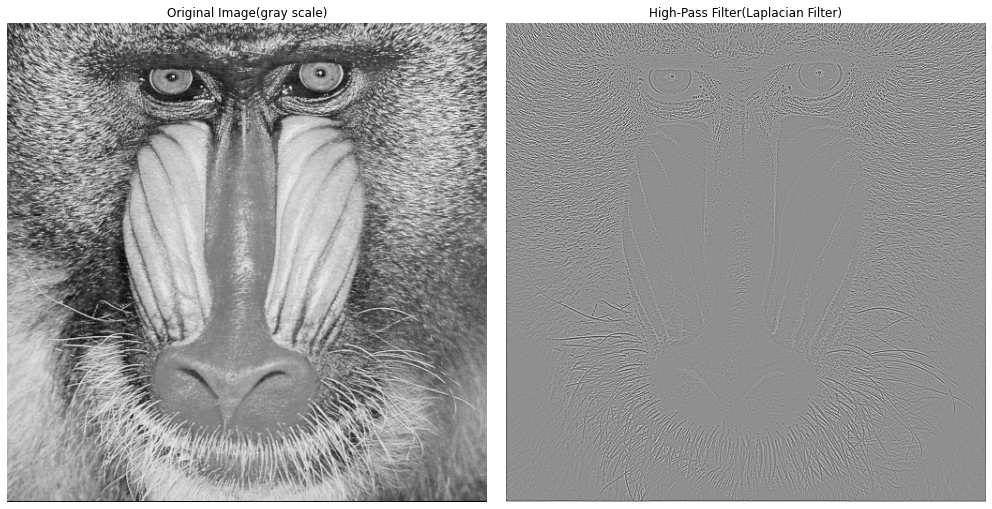

In [22]:
highpass_filter_ = laplacian_filter()
bandpass_filter_result = linear_conv_using_circular_conv(I1, highpass_filter_)

num_rows = 1
fig, axs = plt.subplots(num_rows, 2, figsize=(14, 7))

axs[0].imshow(I1, cmap='gray')
axs[0].set_title('Original Image(gray scale)')
axs[0].axis('off')

axs[1].imshow(bandpass_filter_result, cmap='gray')
axs[1].set_title(f"High-Pass Filter(Laplacian Filter)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Observations :
 - The 3 X 3 Laplacian filter enhances edges by highlighting rapid intensity changes, resulting in sharper edges
 - But, at the cost of amplifying high-frequency noise in the image, leading to amplified noise in the output.
 - Also, tends to blur finer details in the image